In [70]:
from typing import List, Optional
import math

import geopandas as gpd
import movingpandas as mpd
import pandas as pd
from shapely.geometry import Point
from datetime import datetime
import CoT

from geopandas import GeoDataFrame, read_file

In [71]:
# Creating an additional Cursor on Target Class
# To handle a list of objects
# Add additional functions to convert gpkg, dataframes, and calculations.

class Collection(CoT.utils.CustomModel):
    Events: Optional[List[CoT.Event]] = []
    CRS: Optional[str] = None

    def to_dataframe(self):
        data = []
        for event in self.Events:
            data.append({
                "geometry": Point(event.point.lon, event.point.lat),
                "t": event.time,
                "speed": event.detail.track["speed"],
                "course": event.detail.track["course"],
                "trajectory_id": event.detail.track["trajectory_id"],
                "id": event.uid
            })


    
        df = pd.DataFrame(data).set_index("t")
        df.crs = self.CRS
        return df
    
    def from_geopackage(self, path: str):
        df = gpd.read_file(path)
        self.CRS = df.crs
        for _, row in df.iterrows():
            event = CoT.Event(
                uid=str(row["id"]),
                how="h-e",
                time=datetime.strptime(row["t"], "%Y-%m-%d %H:%M:%S+00"),
                start=datetime.strptime(row["t"], "%Y-%m-%d %H:%M:%S+00"),
                stale=datetime.strptime(row["t"], "%Y-%m-%d %H:%M:%S+00"),
                type="u-s-g",
                point=CoT.Point(
                    lon=row.geometry.x,
                    lat=row.geometry.y,
                    hae=0,
                    ce=0,
                    le=0
                ),
                detail=CoT.models.Detail(
                    track={
                        "trajectory_id": str(row["trajectory_id"]),
                        "course": 0,
                        "speed": 0,
                        "crs": df.crs
                    }
                )
            )

            if len(self.Events) > 1:
                self.Events[len(self.Events) - 1].stale = event.time
                event.detail.track["course"] = self.calculate_course(self.Events[len(self.Events) - 1], event)
                event.detail.track["speed"] = self.calculate_speed(self.Events[len(self.Events) - 1], event)

            self.Events.append(event)

    @staticmethod
    def calculate_course(prev_point, curr_point):
        
        dx = curr_point.point.lon - prev_point.point.lon
        dy = curr_point.point.lat - prev_point.point.lat
        return (90 - (math.degrees(math.atan2(dy, dx)) % 360)) % 360
    
    @staticmethod
    def calculate_speed(prev_point, curr_point):
        """
        Calculate the great circle distance in kilometers between two points
        on the earth (specified in decimal degrees)
        """
        # convert decimal degrees to radians
        prev_lon, prev_lat, curr_lon, curr_lat = map(math.radians, [prev_point.point.lon, prev_point.point.lat, curr_point.point.lon, curr_point.point.lat])

        # haversine formula
        dlon = curr_lon - prev_lon
        dlat = curr_lat - prev_lat  
        a = math.sin(dlat/2)**2 + math.cos(prev_lat) * math.cos(curr_lat) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))
        r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
        return c * r

In [72]:
collection = Collection()
collection.from_geopackage("../tests/geolife_small.gpkg")

gdf = GeoDataFrame(collection.to_dataframe(), crs=collection.CRS)
traj_collection = mpd.TrajectoryCollection(gdf, "trajectory_id", t="t", x="X", y="Y")
traj_collection.add_speed(overwrite=True)

troy = traj_collection.trajectories[1]

<Axes: >

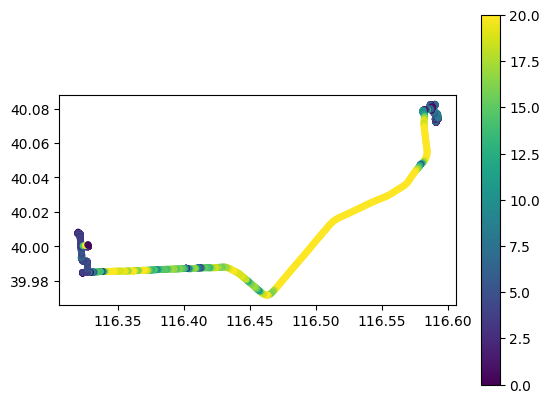

In [73]:
troy.plot(column="speed", linewidth=5, capstyle="round", legend=True, vmax=20)

In [74]:
troy.hvplot(
    c="speed",
    clim=(0, 20),
    line_width=7.0,
    tiles="CartoLight",
    cmap="Viridis",
    colorbar=True,
)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]   (speed)
   .Points.I :Points   [Longitude,Latitude]   (speed,triangle_angle)

<Axes: >

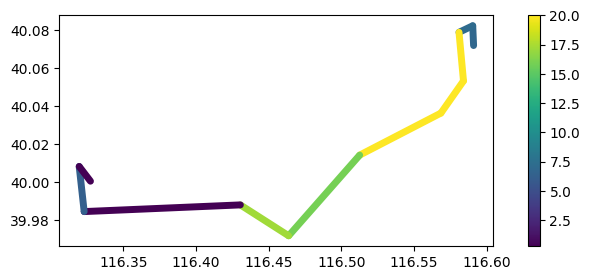

In [75]:
# Generalized trajectory
plot_defaults = {"linewidth": 5, "capstyle": "round", "figsize": (9, 3), "legend": True}
dp_generalized = mpd.DouglasPeuckerGeneralizer(troy).generalize(
    tolerance=0.005
)
dp_generalized.plot(column="speed", vmax=20, **plot_defaults)